### This notebook generates the moisture-precip joint distributions for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [7]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [8]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

In [9]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
file_years = file_concatenator(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
tropical_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) )[:,0]
print(tropical_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_indx]
rad_array = nc_open_compile(file_years,"rad")
rad_ERAI = negative_to_nan(rad_array)[tropical_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERAI = negative_to_nan(ctt_array)[tropical_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_indx]

-56.0
56.0
(408655,)


In [10]:
# applying same for pmax and pacc
pmax_array = nc_open_compile(file_years,"pmax")
pmax_ERAI = negative_to_nan(pmax_array)[tropical_indx]
pacc_array = nc_open_compile(file_years,"pacc")
pacc_ERAI = negative_to_nan(pacc_array)[tropical_indx]*3600 # convert to m3 / h

# extract pressure from the data files
# water vapour levels opened and vstacked, negatives removed
qv_array = nc_open_compile( file_years, "qv", 'stack' )
qv_ERAI = negative_to_nan(qv_array)[tropical_indx]

#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERAI = np.double((xr.open_dataset(file_years[0])).pressure.data)*100

# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
temp_ERAI = nc_open_compile( file_years, "temperature", 'stack' )[tropical_indx]
qvsat_ERAI = eps * satVapP_liq(temp_ERAI) / ( plev_ERAI - satVapP_liq(temp_ERAI) )

In [11]:
#integral computed using trapezoidal integration
integral_ERAI = np.trapz( x=plev_ERAI, y=qv_ERAI )

#integral computed using trapezoidal integration - assuming complete saturation in the column
integral_sat_ERAI = np.trapz( x=plev_ERAI, y=qvsat_ERAI )

#cwvc calculated, the factor of 1000 converts m to mm
cwvc_ERAI = integral_ERAI / (rho_water*g) * 1000
print( 'Min, Mean, and Max CWVC [mm]: ' + str(np.nanmin(cwvc_ERAI)) + ' ' + str(np.nanmean(cwvc_ERAI)) + ' ' + str(np.nanmax(cwvc_ERAI)) )

#csf calculated, multiply by 100 to convert to a %
csf_ERAI = integral_ERAI / integral_sat_ERAI * 100
print( 'Min, Mean, and Max CSF [%]: ' + str(np.nanmin(csf_ERAI)) + ' ' + str(np.nanmean(csf_ERAI)) + ' ' + str(np.nanmax(csf_ERAI)) )

Min, Mean, and Max CWVC [mm]: 5.731840476946688 44.977217866707626 71.06220360060212
Min, Mean, and Max CSF [%]: 8.707810906678603 75.50930129888096 231.26344120992917


### Joint distribution of CSF and MCS precip / accumulation filtering by morphology

In [15]:
# binning for precipitation intensity
xbins1 = np.linspace( 20, 100, 45 )
ybins1 = np.logspace( -1.5, 1.75, 45 )
xbins2 = np.linspace( 20, 100, 45 )
ybins2 = np.logspace( 6, 12, 45 )

# Find the 25th percentile of lifetime to define 'short-lived' (3 hours)
i = np.where( lifetime_ERAI <= np.percentile( lifetime_ERAI, 25 ) )
print(np.percentile( lifetime_ERAI, 25 ))
csf_ERAI_young = csf_ERAI[i]
pmax_ERAI_young = pmax_ERAI[i]
print(pmax_ERAI_young)
pacc_ERAI_young = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_young)) & (~np.isnan(pmax_ERAI_young)) & (~np.isnan(pacc_ERAI_young)) )
h1 = np.histogram2d( csf_ERAI_young[i], pmax_ERAI_young[i], bins=[xbins1, ybins1] )
h7 = np.histogram2d( csf_ERAI_young[i], pacc_ERAI_young[i], bins=[xbins2, ybins2] )

# Find the 75th percentile of lifetime to define 'long-lived' (11 hours)
i = np.where( lifetime_ERAI >= np.percentile( lifetime_ERAI, 75 ) )
csf_ERAI_old = csf_ERAI[i]
pmax_ERAI_old = pmax_ERAI[i]
pacc_ERAI_old = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_old)) & (~np.isnan(pmax_ERAI_old)) & (~np.isnan(pacc_ERAI_old)) )
h2 = np.histogram2d( csf_ERAI_old[i], pmax_ERAI_old[i], bins=[xbins1, ybins1] )
h8 = np.histogram2d( csf_ERAI_old[i], pacc_ERAI_old[i], bins=[xbins2, ybins2] )

# Find the 25th percentile of extent to define 'small' (132 km)
i = np.where( maxrad_ERAI <= np.percentile( maxrad_ERAI, 25) )
csf_ERAI_small = csf_ERAI[i]
pmax_ERAI_small = pmax_ERAI[i]
pacc_ERAI_small = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_small)) & (~np.isnan(pmax_ERAI_small)) & (~np.isnan(pacc_ERAI_small)) )
h3 = np.histogram2d( csf_ERAI_small[i], pmax_ERAI_small[i], bins=[xbins1, ybins1] )
h9 = np.histogram2d( csf_ERAI_small[i], pacc_ERAI_small[i], bins=[xbins2, ybins2] )
i = np.where( rad_ERAI <= np.percentile( rad_ERAI, 25) )
csf_ERAI_small = csf_ERAI[i]
pmax_ERAI_small = pmax_ERAI[i]
pacc_ERAI_small = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_small)) & (~np.isnan(pmax_ERAI_small)) & (~np.isnan(pacc_ERAI_small)) )
h3a = np.histogram2d( csf_ERAI_small[i], pmax_ERAI_small[i], bins=[xbins1, ybins1] )
h9a = np.histogram2d( csf_ERAI_small[i], pacc_ERAI_small[i], bins=[xbins2, ybins2] )

# Find the 75th percentile of extent to define 'large' (400 km)
i = np.where( maxrad_ERAI >= np.percentile( maxrad_ERAI, 75) )
csf_ERAI_big = csf_ERAI[i]
pmax_ERAI_big = pmax_ERAI[i]
pacc_ERAI_big = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_big)) & (~np.isnan(pmax_ERAI_big)) & (~np.isnan(pacc_ERAI_big)) )
h4 = np.histogram2d( csf_ERAI_big[i], pmax_ERAI_big[i], bins=[xbins1, ybins1] )
h10 = np.histogram2d( csf_ERAI_big[i], pacc_ERAI_big[i], bins=[xbins2, ybins2] )
i = np.where( rad_ERAI > np.percentile( rad_ERAI, 75) )
csf_ERAI_big = csf_ERAI[i]
pmax_ERAI_big = pmax_ERAI[i]
pacc_ERAI_big = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_big)) & (~np.isnan(pmax_ERAI_big)) & (~np.isnan(pacc_ERAI_big)) )
h4a = np.histogram2d( csf_ERAI_big[i], pmax_ERAI_big[i], bins=[xbins1, ybins1] )
h10a = np.histogram2d( csf_ERAI_big[i], pacc_ERAI_big[i], bins=[xbins2, ybins2] )

# Find the 25th percentile of CTT to define 'deep' (188 K)
i = np.where( minctt_ERAI <= np.percentile( minctt_ERAI, 25 ) )
csf_ERAI_deep = csf_ERAI[i]
pmax_ERAI_deep = pmax_ERAI[i]
pacc_ERAI_deep = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_deep)) & (~np.isnan(pmax_ERAI_deep)) & (~np.isnan(pacc_ERAI_deep)) )
h5 = np.histogram2d( csf_ERAI_deep[i], pmax_ERAI_deep[i], bins=[xbins1, ybins1] )
h11 = np.histogram2d( csf_ERAI_deep[i], pacc_ERAI_deep[i], bins=[xbins2, ybins2] )

# Find the 75th percentile of CTT to define 'shallow' (201 K)
i = np.where(minctt_ERAI >= np.percentile( minctt_ERAI, 75 ))
csf_ERAI_shallow = csf_ERAI[i]
pmax_ERAI_shallow = pmax_ERAI[i]
pacc_ERAI_shallow = pacc_ERAI[i]
i = np.where( (~np.isnan(csf_ERAI_shallow)) & (~np.isnan(pmax_ERAI_shallow)) & (~np.isnan(pacc_ERAI_shallow)) )
h6 = np.histogram2d( csf_ERAI_shallow[i], pmax_ERAI_shallow[i], bins=[xbins1, ybins1] )
h12 = np.histogram2d( csf_ERAI_shallow[i], pacc_ERAI_shallow[i], bins=[xbins2, ybins2] )

2.0
[ 0.73  0.16  7.86 ... 27.83  7.53 16.49]


## Figure 2 - Joint distribution of CSF and MCS precip intensity (a) and accumulation (b)

In [16]:
font_size = 24
def scatter_hist(x, y, xbins, ybins, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    h = ax.hist2d( x, y, bins=(xbins, ybins), cmap=cm.Blues )
    wgts = np.ones_like(x)/float(len(x))*100
    ax_histx.hist(x, bins=xbins, edgecolor='k', weights=wgts )
    ax_histx.tick_params(axis='both', which='major', labelsize=font_size-5)
    wgts = np.ones_like(y)/float(len(y))*100
    ax_histy.hist(y, bins=ybins, edgecolor='k', weights=wgts, orientation='horizontal')
    ax_histy.tick_params(axis='both', which='major', labelsize=font_size-5)
    ax_histy.set_yscale('log')
    return h

78.18181818181819 1873817422.8603868
74.54545454545455 4806380863.064389
81.81818181818181 1000000000.0
74.54545454545455 4806380863.064389
74.54545454545455 4806380863.064389
78.18181818181819 1873817422.8603868
80.0 1000000000.0
76.36363636363636 31622776601.683792


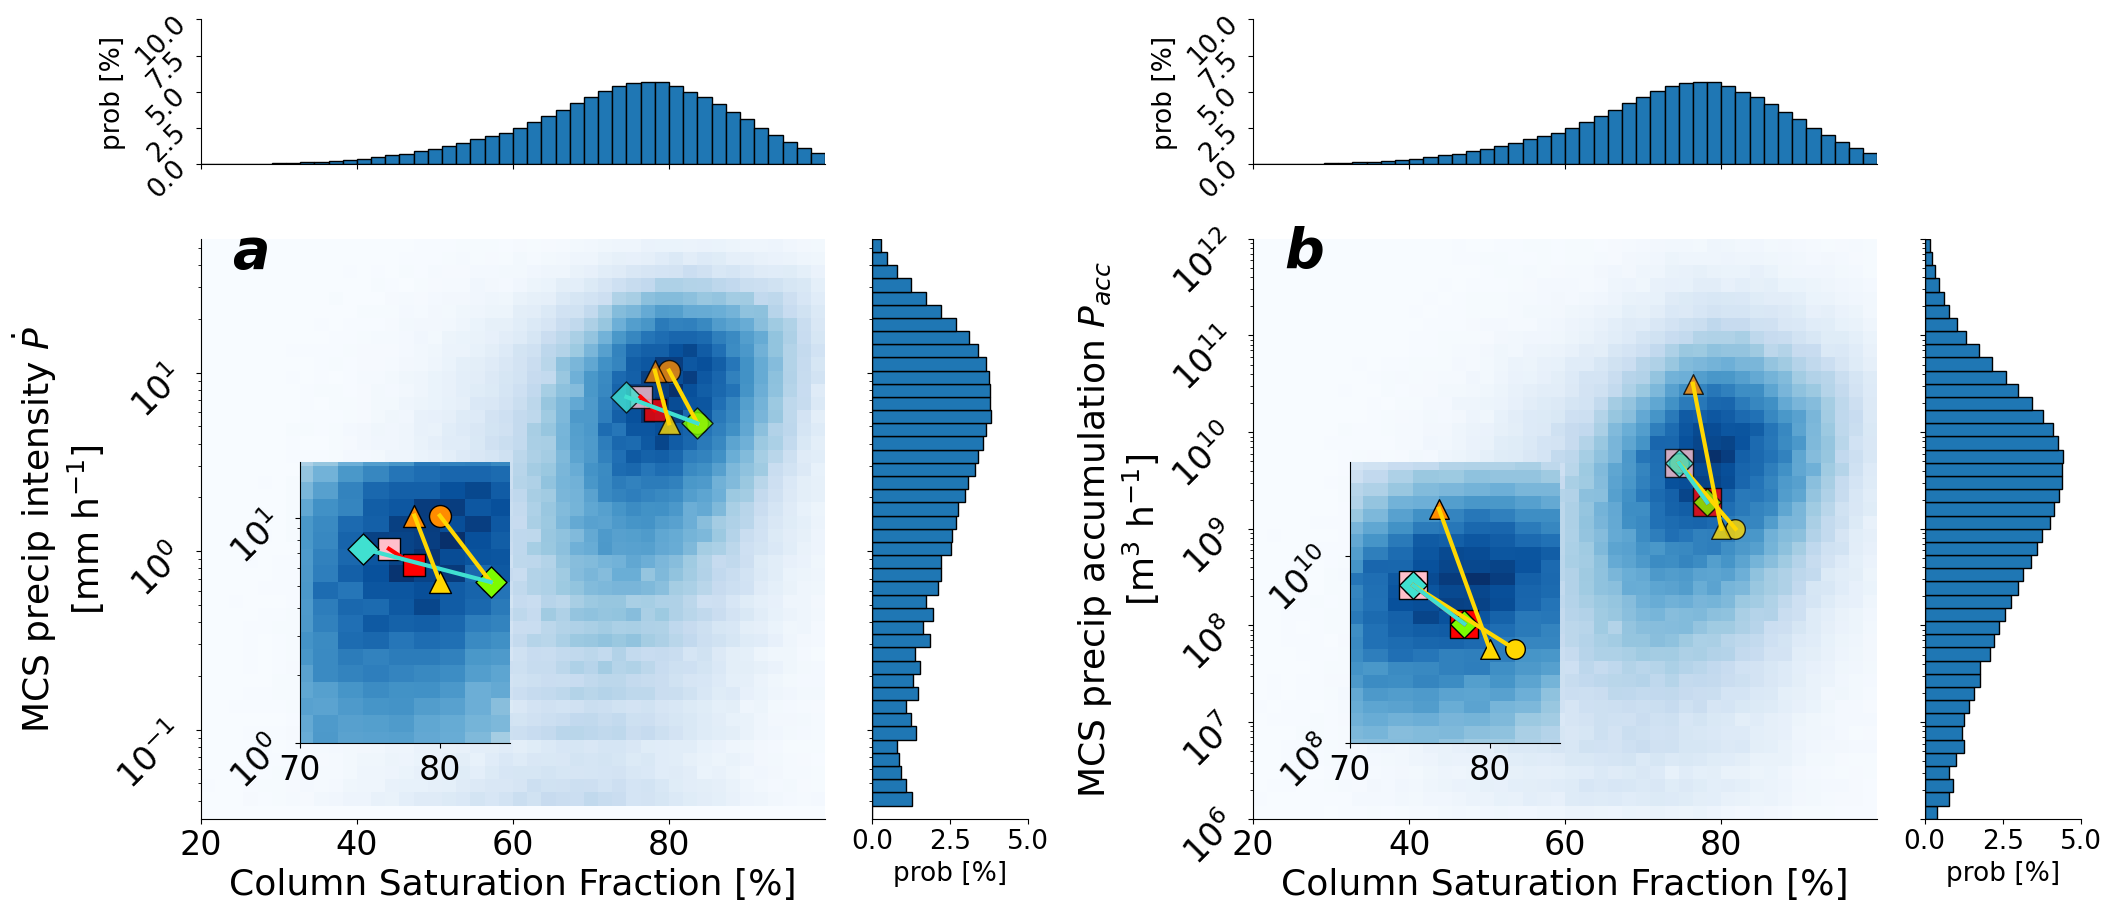

In [23]:
fig = plt.figure( figsize=(21, 9), constrained_layout=True )
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})
gs = fig.add_gridspec( 2, 4, width_ratios=(4, 1, 4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9,
                     wspace=0.05, hspace=0.05 )
ax1 = fig.add_subplot( gs[1,0] )
ax1_histx = fig.add_subplot( gs[0,0], sharex=ax1 )
ax1_histy = fig.add_subplot( gs[1,1], sharey=ax1 )

## main panel a
i = np.where( (~np.isnan(csf_ERAI)) & (~np.isnan(pmax_ERAI)) )
scatter_hist( csf_ERAI[i], pmax_ERAI[i], xbins1, ybins1, ax1, ax1_histx, ax1_histy )
ax1.set_xticks( [20, 40, 60, 80] )
ax1_histx.set_ylabel( 'prob [%]', fontsize=font_size-5 )
ax1_histx.set_yticks( [0, 2.5, 5, 7.5, 10], rotation=45 )
ax1_histy.set_xlabel( 'prob [%]', fontsize=font_size-5 )
ax1_histy.set_xticks( [0, 2.5, 5], rotation=45 )
ax1.set_ylabel( r'MCS precip intensity $\dot{P}$ '
              '\n'
              '[mm h$^{-1}$]' )
ax1.set_xlabel( 'Column Saturation Fraction [%]' )
ax1.text( 0.05, 0.95, 'a', style='italic', weight='bold', fontsize=40, transform=ax1.transAxes )
##

## inset panel a
left, bottom, width, height = [0.14, 0.18, 0.1, 0.3125]
ax3 = fig.add_axes([left, bottom, width, height])
ax3.hist2d( csf_ERAI[i], pmax_ERAI[i], bins=(xbins1, ybins1), cmap=cm.Blues )
ax3.set_xlim( [70, 85] )
ax3.set_yscale( 'log' )
ax3.set_ylim( [1, 10**1.25] )

# Where is the center of mass of the joint distribution for young/old/big/small systems? 
# (The cells below must be run for this.)
h_csfpmax = [ h1, h2, h3, h4, h5, h6, h3a, h4a ]
farbe = [ 'red', 'pink', 'gold', 'darkorange', 'turquoise', 'lawngreen', 'gold', 'darkorange' ]
forme = [ 's', 's', 'o', 'o', 'D', 'D', '^', '^' ]
#grose = [ 200, 200, 200, 200, 200, 200 ]
for i, histo, f, s in zip( np.arange(8), h_csfpmax, farbe, forme ):
    l, m = unravel_index( histo[0].argmax(), histo[0].shape )
    ax1.scatter( xbins1[l], ybins1[m], marker=s, color=f, s=250, zorder=5, edgecolor='k', alpha=0.8 )
    ax3.scatter( xbins1[l], ybins1[m], marker=s, color=f, s=250, zorder=5, edgecolor='k' )
    if i%2 == 0:
        ll, mm = unravel_index( h_csfpmax[i+1][0].argmax(), h_csfpmax[i+1][0].shape )
        ax1.plot( [xbins1[l], xbins1[ll]], [ybins1[m], ybins1[mm]], lw=3, color=f, zorder=10 )
        ax3.plot( [xbins1[l], xbins1[ll]], [ybins1[m], ybins1[mm]], lw=3, color=f, zorder=10 )

## main panel b
ax2 = fig.add_subplot( gs[1,2] )
ax2_histx = fig.add_subplot( gs[0,2], sharex=ax2 )
ax2_histy = fig.add_subplot( gs[1,3], sharey=ax2 )
i = np.where( (~np.isnan(csf_ERAI)) & (~np.isnan(pacc_ERAI)) )
scatter_hist( csf_ERAI[i], pacc_ERAI[i], xbins2, ybins2, ax2, ax2_histx, ax2_histy )

ax2.set_xticks( [20, 40, 60, 80] )
ax2_histx.set_ylabel( 'prob [%]', fontsize=font_size-5 )
ax2_histx.set_yticks( [0, 2.5, 5, 7.5, 10], rotation=45 )
ax2_histy.set_xlabel( 'prob [%]', fontsize=font_size-5 )
ax2_histy.set_xticks( [0, 2.5, 5], rotation=45 )
ax2.set_ylabel( 'MCS precip accumulation $P_{acc}$'
              '\n'
              '[m$^3$ h$^{-1}$]' )
ax2.set_xlabel( 'Column Saturation Fraction [%]' )
ax2.text( 0.05, 0.95, 'b', style='italic', weight='bold', fontsize=40, transform=ax2.transAxes )
##

## inset panel b
left, bottom, width, height = [0.64, 0.18, 0.1, 0.3125]
ax4 = fig.add_axes([left, bottom, width, height])
ax4.hist2d( csf_ERAI[i], pacc_ERAI[i], bins=(xbins2, ybins2), cmap=cm.Blues )
ax4.set_xlim( [70, 85] )
ax4.set_yscale( 'log' )
ax4.set_ylim( [10**8, 10**11] )

h_csfpacc = [ h7, h8, h9, h10, h11, h12, h9a, h10a ]
farbe = [ 'red', 'pink', 'gold', 'darkorange', 'turquoise', 'lawngreen', 'gold', 'darkorange' ]
forme = [ 's', 's', 'o', 'o', 'D', 'D', '^', '^' ]
grose = [ 400, 400, 200, 200, 200, 200, 200, 200 ]
for i, histo, f, s, z in zip( np.arange(8), h_csfpacc, farbe, forme, grose ):
    l, m = unravel_index( histo[0].argmax(), histo[0].shape )
    ax2.scatter( xbins2[l], ybins2[m], marker=s, color=f, s=z, zorder=5, edgecolor='k', alpha=0.8 )
    ax4.scatter( xbins2[l], ybins2[m], marker=s, color=f, s=z, zorder=5, edgecolor='k' )
    print(xbins2[l],ybins2[m])
    if i%2 == 0:
        ll, mm = unravel_index( h_csfpacc[i+1][0].argmax(), h_csfpacc[i+1][0].shape )
        ax2.plot( [xbins2[l], xbins2[ll]], [ybins2[m], ybins2[mm]], lw=3, color=f, zorder=10 )
        ax4.plot( [xbins2[l], xbins2[ll]], [ybins2[m], ybins2[mm]], lw=3, color=f, zorder=10 )
##

for a in ax1, ax1_histx, ax1_histy, ax2, ax2_histx, ax2_histy, ax3, ax4:
    a.spines['top'].set_visible( False )
    a.spines['right'].set_visible( False )
    for t in a.get_yticklabels():
        t.set_rotation(45)

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-pacc-ERAI.pdf', bbox_inches='tight' )
plt.show()